# scqubits example: the variational-tight-binding method
J. Koch and P. Groszkowski

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

---

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scqubits as scq

# VTB

For certain large systems of interest, the charge basis is not suitable for the purposes of generating spectra. If the low-energy eigenstates are relatively localized to minima of the potential, then a description in terms of tight-binding states is preferrable. Such states are not well described by free particle charge basis states. The VTB method proceeds by expressing the Hamiltonian of a superconducting qubit in terms of tight binding states. A wrinkle that we will address is that tight binding states - even states defined with respect to the same minimum - are not orthogonal. Therefore when we calculate the eigenspectrum of a qubit using tight-binding states, we must solve a generalized eigenvalue problem.

For pedagogical purposes, we will use as our first example the flux qubit, which has two degrees of freedom. This qubit can be easily diagonalized in the charge basis: see `FluxQubit` for such an implementation. 

## Example: flux qubit using VTB

$H_\text{flux}=(n_{i}-n_{gi})4(E_\text{C})_{ij}(n_{j}-n_{gj})
                -E_{J}\cos\phi_{1}-E_{J}\cos\phi_{2}-\alpha E_{J}\cos(2\pi f + \phi_{1} - \phi_{2}),$
                with a sum over $i,j\in\{1,2\}$ implied.

We create an instance of the flux qubit using VTB by calling

In [2]:
EJ = 1.0
ECJ = EJ / 60.0
ALPHA = 0.8
FLUX = 0.48
ECg = 50.0 * ECJ
EJlist = np.array([1.01*EJ, 0.98*EJ, ALPHA * EJ])
nglist = np.array([0.2, 0.0])
num_exc = 7
maximum_periodic_vector_length = 8
fluxqubitVTB = scq.FluxQubitVTB(EJ1=EJ,
    EJ2=EJ,
    EJ3=ALPHA * EJ,
    ECJ1=ECJ,
    ECJ2=ECJ,
    ECJ3=ECJ / ALPHA,
    ECg1=ECg,
    ECg2=ECg,
    ng1=nglist[0],
    ng2=nglist[1],
    flux=FLUX,
    num_exc=num_exc,
    maximum_periodic_vector_length=maximum_periodic_vector_length,
    truncated_dim=6)
# Comparison with the standard charge basis implementation
fluxqubit = scq.FluxQubit(EJ1=EJ,
    EJ2=EJ,
    EJ3=ALPHA * EJ,
    ECJ1=ECJ,
    ECJ2=ECJ,
    ECJ3=ECJ / ALPHA,
    ECg1=ECg,
    ECg2=ECg,
    ng1=nglist[0],
    ng2=nglist[1],
    flux=FLUX,
    ncut=10,
    truncated_dim=6)

Note that we instantiate a `FluxQubitVTB` object in the same way as a `FluxQubit` object, except for eliminating the argument `ncut`, corresponding to the charge basis cutoff, and adding `num_exc`, the number of excitations per mode, per minimum, and `maximum_periodic_vector_length`, which specifies the maximum Manhattan length of a unit cell vector that we consider (we explain this further below).

Before getting into the nitty-gritty details, we note that `***VTB` qubits have the same functionality as "standard" qubits defined in the `scqubits` library. We can instantiate them using ipywidgets

In [12]:
fluxqubitVTB2 = scq.FluxQubitVTB.create()

Output()

In [13]:
print(fluxqubitVTB2)

FluxQubitVTB--------|
                    | EJ1: 1.0
                    | EJ2: 1.0
                    | EJ3: 0.8
                    | ECJ1: 0.1
                    | ECJ2: 0.1
                    | ECJ3: 0.125
                    | ECg1: 5.0
                    | ECg2: 5.0
                    | ng1: 0.0
                    | ng2: 0.0
                    | flux: 0.46
                    | num_exc: 3
                    | maximum_periodic_vector_length: 8
                    | truncated_dim: 6
                    |
                    | dim: 32



We can solve for eigenvalues and eigenvectors

In [3]:
evalsVTB, evecsVTB = fluxqubitVTB.eigensys()
evalsVTB

array([1.53361105, 1.7047771 , 1.73740897, 1.80376339, 1.85268889,
       1.94129265])

plot those eigenvalues

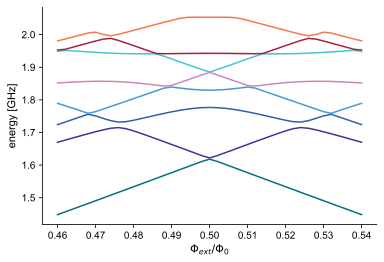

In [4]:
flux_list = np.linspace(0.46, 0.54, 41)
fluxqubitVTB.plot_evals_vs_paramvals('flux', flux_list, evals_count=8);

and calculate and plot matrix elements

In [5]:
expiphi2matVTB = fluxqubitVTB.matrixelement_table('exp_i_phi_2_operator',
                                                  evals_count=4)

print(expiphi2matVTB)

[[ 0.60484912+0.68516281j -0.04007424+0.04978205j -0.15499975+0.14012041j
   0.0240676 +0.30959635j]
 [-0.04010521+0.05082796j  0.61233926-0.59729371j  0.05675022+0.31273926j
  -0.01127813+0.02682014j]
 [-0.15496275+0.14230659j  0.0589198 +0.30847514j  0.65640999+0.39167883j
  -0.05799673+0.09869194j]
 [-0.29373506-0.10069047j -0.0180587 -0.02381485j -0.06585403-0.09383004j
   0.4653111 +0.63925936j]]


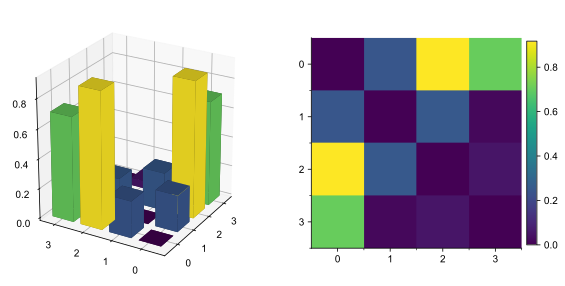

In [6]:
fluxqubitVTB.plot_matrixelements('n_1_operator', evals_count=4);

We note that for the parameters considered here, these calculations show excellent agreement with charge basis results

In [7]:
expiphimatCB = fluxqubit.matrixelement_table('exp_i_phi_2_operator',
                                                evals_count=4)
np.max(np.abs(expiphi2matVTB) - np.abs(expiphimatCB))

0.002732357367177085

In [8]:
evalsCB = fluxqubit.eigenvals()
np.max(np.abs(evalsVTB - evalsCB))

2.6982161179134323e-05

## Details of the VTB Calculation

The first step of the VTB calculation is finding the minimum locations where our ansatz tight-binding states will be placed. The code calls the qubit-specific function `find_minima` which finds all minima locations within the first unit cell. By default, ansatz states will be placed in all minima. In the case of the flux qubit near the half-flux frustration point, there are two inequivalent minima in the first unit cell

In [9]:
fluxqubitVTB.find_minima()

array([[-0.87102913,  0.87102901],
       [ 0.91538277, -0.91538227]])

The VTB calculation involves computing matrix elements between Bloch states. `maximum_periodic_vector_length` specifies which unit cell vectors we consider

![title](vtb_figs/max_rel_per_vec.png)

We also specifiy `maximum_site_length`, which by default is set to 2, which specifies the maximum entry of a given unit cell vector. For example is `maximum_site_length=2`, then the vector (3, 0) would not be allowed even if `maximum_periodic_vector_length=4`.

The calculation proceeds by calling `find_relevant_unit_cell_vectors`. We say "relevant" because some unit cell vectors lead to negligible overlap between localized states and can be safely neglected. This calculation in general must be done for each pair of minima

![title](vtb_figs/find_rel_1.png)

In [10]:
fluxqubitVTB.find_relevant_unit_cell_vectors()

{(0,
  0): array([[ 0,  0],
        [ 1,  0],
        [-1,  0],
        [ 0,  1],
        [ 0, -1]]),
 (1,
  1): array([[ 0,  0],
        [ 1,  0],
        [-1,  0],
        [ 0,  1],
        [ 0, -1]]),
 (0,
  1): array([[ 0,  0],
        [-1,  0],
        [ 0,  1]])}

The keys refer to which minima pair we are considering, and the values are the relevant unit cell vectors.

Distance between minima is however not the entire story: we are actually interested in the overlap of wavefunctions centered on the two minima. The harmonic mode directions and lengths are specified by the matrix $\Xi$, $\phi_{i}=\frac{1}{\sqrt{2}}\sum_{\mu}\Xi_{i\mu}(a_{\mu}+a_{\mu}^{\dagger})$, $n_{i}=\frac{-i\hbar}{\sqrt{2}}\sum_{\mu}\Xi_{i\mu}^{-t}(a_{\mu}+a_{\mu}^{\dagger})$. We choose as our metric the overlap between ground state harmonic oscillator wavefunctions $e^{-\frac{1}{4}\left|\Xi^{-1}\left(2\pi\vec{j}+\vec{\phi}^{(m)}-\vec{\phi}^{(m')}\right)\right|^2}$, where $\vec{\phi}^{(m)}$ specifies a minimum indexed by $m$ and $\vec{j}$ refers to a unit cell vector.

![title](vtb_figs/find_rel_2.png)

Having found the relevant unit cell vectors, we can calculate the matrix elements we need for our calculation. For computing eigenvalues, this involves Hamiltonian matrix elements, as well as inner product matrix elements (again, VTB states are not orthogonal). 

### Harmonic Length Optimization

We allow for the modification $\Xi_{i\mu}\rightarrow\lambda_{\mu}\Xi_{i\mu}$ where $\lambda_{\mu}$ is treated as a variational parameter for each mode. We find the optimal $\lambda_{\mu}$ that minimize the energy of our ansatz ground-state wavefunction. For potentials where the local curvature around each minimum is almost exactly harmonic, this modification will do little (we will find $\lambda_{\mu}\rightarrow 1$). However with significant anharmonic deviations, this modification can result in a significant lowering of the ground-state-energy estimate. For a demonstration of this lowering we introduce the current-mirror qubit 

In [14]:
currentmirrorVTB = scq.CurrentMirrorVTB.create()

In [15]:
print(currentmirrorVTB)

CurrentMirrorVTB----|
                    | N: 3
                    | ECB: 0.2
                    | ECJ: 35.0
                    | ECg: 45.0
                    | EJlist: [10. 10. 10. 10. 10. 10.]
                    | nglist: [0. 0. 0. 0. 0.]
                    | flux: 0.0
                    | num_exc: 2
                    | maximum_periodic_vector_length: 8
                    | truncated_dim: 6
                    |
                    | dim: 729



First, without HLO

In [16]:
currentmirrorVTB.eigenvals()

array([45.84743654, 48.06652458, 48.07297944, 50.26304672, 50.277352  ,
       50.28090015])

In [17]:
currentmirrorVTB.harmonic_length_optimization=True

In [18]:
currentmirrorVTB.eigenvals()

completed harmonic length optimization for the m=0 minimum


array([45.40032294, 47.38893244, 47.39146658, 49.31617558, 49.33859855,
       49.35982434])

For this set of parameters, HLO gives a ground-state energy estimate that is ~450 MHz lower than the naive estimate!

## Global excitation number cutoff

We additionally allow for a Hilbert space truncation scheme whereby instead of allowing for a certain number of excitations per mode per minimum, we allow for a total number of excitations per minimum. That is, if we have a 2 d.o.f. qubit and we label the number of excitations in each mode as $(num_1, num_2)$, then with a global excitation number cutoff of 2, we retain the states $(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (0, 2)$. This is in contrast to the regular excitation number cutoff scheme, where for a cutoff of 2 the state $(2, 1)$ would be retained. This scheme allows us to simulate larger circuits, retaining only